## Описание проекта
Вы работаете в стартапе, который продаёт продукты питания. Нужно разобраться, как ведут себя пользователи вашего мобильного приложения.
Изучите воронку продаж. Узнайте, как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

После этого исследуйте результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

## Оглавление
1. [Шаг 1. Открытие данных](#start)
2. [Шаг 2. Подготовьте данные](#preprocessing)
    * [Привести данные к правильному типу](#formatdata)
    * [Обработка дубликатов](#duplicates)
3. [Шаг 3. Изучите и проверьте данные](#check)
4. [Шаг 4. Изучите воронку событий](#funnel)
    * [Какие события есть в логах, как часто они встречаются](#frequency)
    * [Сколько пользователей совершали каждое из этих событий. Доля пользователей, которые хоть раз совершали событие](#users_count)
    * [В каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку?](#order)
    * [Какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем)](#conversion)
    * [На каком шаге теряете больше всего пользователей?](#losses)
    * [Какая доля пользователей доходит от первого события до оплаты?](#conversion_first_event_purchase)
5. [ Шаг 5. Изучите результаты эксперимента](#check_results)
    * [Сколько пользователей в каждой экспериментальной группе?](#users_in_groups)
    * [Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие](#main_event)
    * [Доля пользователей, совершивших события. Есть ли статистически достоверное отличие](#check_funnel_in_groups)
    * [Можно ли сказать, что разбиение на группы работает корректно?](#divide_groups)
    * [Сравните результаты с объединённой контрольной группой](#check_funnel_in_united_control)
    * [Посчитайте, сколько проверок статистических гипотез вы сделали](#numbers_compare)
    * [Какой уровень значимости стоит применить?](#alpha)
6. [Вывод](#result)

# Шаг 1. Откройте файл с данными и изучите общую информацию
<a id="start"></a>

In [1]:
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from plotly import graph_objects as go
import pandas as pd
import io
import requests
import numpy as np
from scipy import stats as st
import math as mth
logs = pd.read_csv('/datasets/logs_exp.csv', sep='\t')

In [2]:
pd.set_option('display.max_rows', 30)
display(logs)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


In [3]:
#изучим данные
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
EventName         244126 non-null object
DeviceIDHash      244126 non-null int64
EventTimestamp    244126 non-null int64
ExpId             244126 non-null int64
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


### Данные
- Ура, пропусков нет!
- EventTimestamp нужно конвертировать в дату

In [4]:
logs = logs.rename(columns=({'EventName':'event_name', 'DeviceIDHash': 'hash', 'EventTimestamp': 'event_time_stamp', 'ExpId': 'exp_id'}))

In [5]:
logs

,event_name,hash,event_time_stamp,exp_id
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248
...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247
244122,MainScreenAppear,5849806612437486590,1565212439,246
244123,MainScreenAppear,5746969938801999050,1565212483,246
244124,MainScreenAppear,5746969938801999050,1565212498,246


# Шаг 2. Предобработка данных
<a id="preprocessing"></a>

## Привести данные к правильному типу
<a id="formatdata"></a>

### Добавьте столбец даты и времени

In [6]:
# конвертируем EventTimestamp в дату/время и сохраним в новом столбце event_datetime
logs['event_datetime'] = pd.to_datetime(logs['event_time_stamp'], unit='s')
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 5 columns):
event_name          244126 non-null object
hash                244126 non-null int64
event_time_stamp    244126 non-null int64
exp_id              244126 non-null int64
event_datetime      244126 non-null datetime64[ns]
dtypes: datetime64[ns](1), int64(3), object(1)
memory usage: 9.3+ MB


### Добавьте отдельный столбец дат

In [7]:
#выделяю дату в отдельный столбец event_date
logs['event_date'] =logs['event_datetime'].dt.round('1D')
logs

,event_name,hash,event_time_stamp,exp_id,event_datetime,event_date
0,MainScreenAppear,4575588528974610257,1564029816,246,2019-07-25 04:43:36,2019-07-25
1,MainScreenAppear,7416695313311560658,1564053102,246,2019-07-25 11:11:42,2019-07-25
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
3,CartScreenAppear,3518123091307005509,1564054127,248,2019-07-25 11:28:47,2019-07-25
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248,2019-07-25 11:48:42,2019-07-25
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-08
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-08
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-08
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-08


In [8]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 6 columns):
event_name          244126 non-null object
hash                244126 non-null int64
event_time_stamp    244126 non-null int64
exp_id              244126 non-null int64
event_datetime      244126 non-null datetime64[ns]
event_date          244126 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 11.2+ MB


##  Обработка дубликатов
<a id="duplicates"></a>

In [9]:
print ('Полных дубликатов в таблице:', logs.duplicated().sum())

Полных дубликатов в таблице: 413


In [10]:
# посмотрим что за дубликаты. выделю их в датафрейм doubles
doubles = logs[logs.duplicated() == True]
#pd.set_option('display.max_rows', 30)
doubles.sort_values('hash').head(30)

,event_name,hash,event_time_stamp,exp_id,event_datetime,event_date
130558,MainScreenAppear,33176906322804559,1564933075,248,2019-08-04 15:37:55,2019-08-05
130995,OffersScreenAppear,33176906322804559,1564933763,248,2019-08-04 15:49:23,2019-08-05
104108,CartScreenAppear,34565258828294726,1564857221,248,2019-08-03 18:33:41,2019-08-04
159302,PaymentScreenSuccessful,54903596035630984,1565011672,248,2019-08-05 13:27:52,2019-08-06
176813,PaymentScreenSuccessful,77364241990273403,1565044732,246,2019-08-05 22:38:52,2019-08-06
189896,MainScreenAppear,91292479590032512,1565087723,246,2019-08-06 10:35:23,2019-08-06
155464,MainScreenAppear,95206628315371849,1565005724,247,2019-08-05 11:48:44,2019-08-05
110479,MainScreenAppear,170935625628929269,1564897487,246,2019-08-04 05:44:47,2019-08-04
34223,CartScreenAppear,197027893265565660,1564684544,246,2019-08-01 18:35:44,2019-08-02
17037,CartScreenAppear,197027893265565660,1564659614,246,2019-08-01 11:40:14,2019-08-01


In [11]:
# вернем настройку отображения количества строк обратно
#pd.set_option('display.max_rows', 30)

In [12]:
#поисследуем какие события есть в дубликатах. Посмотрим по группам экспериментов количество событий 
pivot_t = (doubles.pivot_table(index='event_name', columns= 'exp_id', values='event_time_stamp', aggfunc='count')
           .sort_values(by='event_name', ascending=False))
pivot_t

exp_id,246,247,248
event_name,,,
Tutorial,6,5,23
PaymentScreenSuccessful,58,62,75
OffersScreenAppear,6,3,8
MainScreenAppear,32,33,39
CartScreenAppear,21,22,20


In [13]:
#Сколько уникальных пользователей имеет задублированные записи
users_unique_doubled = doubles['hash'].nunique()
users_unique_doubled

237

In [14]:
# Сколько всего уникальных пользователей
users_unique = logs['hash'].nunique()
users_unique

7551

In [15]:
# какой процент от всех пользователей имеет задублированные записи
users_persent_doubled = users_unique_doubled/users_unique * 100
users_persent_doubled

3.1386571315057608

### Полных дубликатов 413. Их немного относительно размера датасета 244126 - поэтому удаляем

In [16]:
#удалим дубли
logs = logs.drop_duplicates()

In [17]:
logs.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 243713 entries, 0 to 244125
Data columns (total 6 columns):
event_name          243713 non-null object
hash                243713 non-null int64
event_time_stamp    243713 non-null int64
exp_id              243713 non-null int64
event_datetime      243713 non-null datetime64[ns]
event_date          243713 non-null datetime64[ns]
dtypes: datetime64[ns](2), int64(3), object(1)
memory usage: 13.0+ MB


# Шаг 3. Изучите и проверьте данные
<a id="check"></a>

### Сколько всего событий в логе?


In [18]:
print('Количество событий в логе', len(logs))

Количество событий в логе 243713


#### Ответ:  Записей в логе событий после очистки от дубликатов - 244126. Соответственно, столько же и событий, так как 1 запись = 1 событие
----

### Сколько всего пользователей в логе?

In [19]:
unique_users = logs['hash'].nunique()
print('Количество уникальных пользователей в логе', unique_users)

Количество уникальных пользователей в логе 7551


#### Ответ: Количество уникальных пользователей в логе - 7551
----

### Сколько в среднем событий приходится на пользователя?

In [20]:
events_per_user = logs.groupby(['hash']).agg({'event_name':'count'})['event_name']
mean_events_per_user = events_per_user.mean()
print('Среднее количество событий на пользователя', mean_events_per_user)

median_events_per_user = events_per_user.median()
print('Медианное количество событий на пользователя', median_events_per_user)

Среднее количество событий на пользователя 32.27559263673685
Медианное количество событий на пользователя 20.0


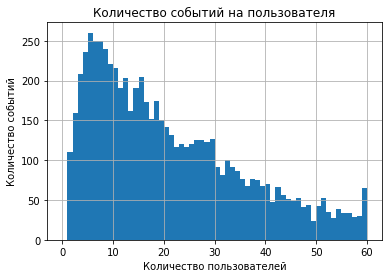

In [21]:
#посмотрим распределение количества событий на пользователя на гистограмме

plt.xlabel('Количество пользователей')
plt.ylabel('Количество событий')
plt.title('Количество событий на пользователя')
events_per_user.hist(range=(0,60), bins=60)
plt.show();

In [22]:
# Посмотрим топ пользователей, которые генерят больше всего событий
events_per_user.sort_values(ascending=False).head(30)

hash
6304868067479728361    2307
197027893265565660     1998
4623191541214045580    1768
6932517045703054087    1439
1754140665440434215    1221
3337471580007169353    1186
7738058666231999878     888
1055544042902443290     854
4713748699910253089     824
8118046800480174342     755
1989685320445148348     729
3521696259961091617     702
3610536745613892312     661
1100007125648169445     661
2305766456715991733     658
5996739817823449506     585
3940194724501792579     569
8173190940950873857     555
2768580714092136945     529
674541835027541643      496
2910761286178294850     489
6613527411922640441     468
4148267947677649217     418
3198863056321683492     413
4705890939205361551     385
4257848154605915902     380
8876255867200307343     364
8309980273750324949     363
5444091050002420401     321
1872978591788881482     321
Name: event_name, dtype: int64

#### Ответ: в среднем на пользователя приходится 32 события. В медиане - 20 событий
#### На гистограмме видно, что много пользователей генерит 5-20 событий. А далее тренд нисходящий
#### Есть пользователи, которые генерят ультра-большое количество событий. Топ-30 пользователей создает от 300 до 2308 событий
----

### Данными за какой период вы располагаете? Найдите максимальную и минимальную дату. Постройте гистограмму по дате и времени.

In [23]:
print('Мы располагаем данными с {} по {}'.format(logs['event_date'].min().strftime('%Y-%m-%d'),logs['event_date'].max().strftime('%Y-%m-%d')))

Мы располагаем данными с 2019-07-25 по 2019-08-08


In [24]:
# сгруппируем лог по дате. Подсчитаем события, произошедшие в дату
events_per_date = logs.groupby(['event_date']).agg({'event_name':'count'}).reset_index()
#events_per_date['event_date'] = events_per_date['event_date'].astype(str)
events_per_date

,event_date,event_name
0,2019-07-25,6
1,2019-07-26,11
2,2019-07-27,51
3,2019-07-28,60
4,2019-07-29,116
5,2019-07-30,303
6,2019-07-31,612
7,2019-08-01,16617
8,2019-08-02,37519
9,2019-08-03,34358


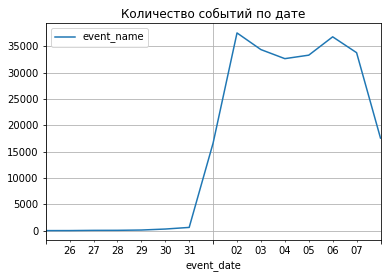

In [25]:
g= events_per_date.plot(grid=True, x='event_date', y = 'event_name', alpha=1)
plt.title('Количество событий по дате')

loc, labels = plt.xticks()
g.set_xticklabels(labels, rotation=45);
plt.show()

#### Судя по графику, резкий рост количества событий произошел 2019-08-02
----

### Можно ли быть уверенным, что у вас одинаково полные данные за весь период? Технически в логи новых дней по некоторым пользователям могут «доезжать» события из прошлого — это может «перекашивать данные». Определите, с какого момента данные полные и отбросьте более старые. 

#### Ответ 1: судя по графику из прошлого пункта полностью доехали события начиная с 2019-08-02

In [26]:
# отбросим более старые данные
logs_full_date = logs.query('event_date > "2019-08-01" ')
logs_full_date

,event_name,hash,event_time_stamp,exp_id,event_datetime,event_date
17798,PaymentScreenSuccessful,3584863859538494504,1564660802,246,2019-08-01 12:00:02,2019-08-02
17799,CartScreenAppear,3584863859538494504,1564660803,246,2019-08-01 12:00:03,2019-08-02
17800,PaymentScreenSuccessful,7238309430968098875,1564660805,248,2019-08-01 12:00:05,2019-08-02
17801,CartScreenAppear,7238309430968098875,1564660805,248,2019-08-01 12:00:05,2019-08-02
17802,OffersScreenAppear,3584863859538494504,1564660807,246,2019-08-01 12:00:07,2019-08-02
...,...,...,...,...,...,...
244121,MainScreenAppear,4599628364049201812,1565212345,247,2019-08-07 21:12:25,2019-08-08
244122,MainScreenAppear,5849806612437486590,1565212439,246,2019-08-07 21:13:59,2019-08-08
244123,MainScreenAppear,5746969938801999050,1565212483,246,2019-08-07 21:14:43,2019-08-08
244124,MainScreenAppear,5746969938801999050,1565212498,246,2019-08-07 21:14:58,2019-08-08


#### Ответ: полные данные есть с 2019-08-02
----

### Данными за какой период времени вы располагаете на самом деле?
### Много ли событий и пользователей вы потеряли, отбросив старые данные?
### Проверьте, что у вас есть пользователи из всех трёх экспериментальных групп.

In [27]:
log_loss =  len(logs) - len(logs_full_date)
print('Потеряли событий после чистки недоехавших данных',log_loss, ', это составляет процент потерь', log_loss/len(logs)*100)

Потеряли событий после чистки недоехавших данных 17776 , это составляет процент потерь 7.293825113966017


In [28]:
# посмотрим количество уникальных пользователей, которое мы потеряем при чистке неполных данных
log_loss_data =  logs.query('event_date < "2019-08-02" ')
users_lost = log_loss_data['hash'].nunique()

print('Потеряли пользователей после чистки недоехавших данных:',users_lost)

Потеряли пользователей после чистки недоехавших данных: 3039


In [29]:
print('Мы располагаем ПОЛНЫМИ данными с {} по {}'.format(logs_full_date['event_date'].min().strftime('%Y-%m-%d'),logs_full_date['event_date'].max().strftime('%Y-%m-%d')))

Мы располагаем ПОЛНЫМИ данными с 2019-08-02 по 2019-08-08


In [30]:
# посмотрим по очищенной от неполных данных таблице количество уникальных пользователей в группах
users_in_groups = (logs_full_date.pivot_table(index='exp_id', values='hash', aggfunc= 'nunique')
           .sort_values(by='hash', ascending=False))
users_in_groups

,exp_id,hash
exp_id,,
248,1,2503
247,1,2480
246,1,2450


#### Ответ: Мы располагаем ПОЛНЫМИ данными с 2019-08-02 по 2019-08-08
#### Удалили 17798 событий, что составило 7,29% потерь от общего количество записей в логе
#### Потеряли пользователей после чистки недоехавших данных: 3039
#### В каждой группе есть уникальные пользователи (примерно 2450-2503) после очистки данных 
---

In [54]:
print(f"Пользователей  до фильтрации по дате: {logs['hash'].nunique()}")
print(f"Пользователей  после фильтрации по дате: {logs_full_date['hash'].nunique()}")

Пользователей  до фильтрации по дате: 7551
Пользователей  после фильтрации по дате: 7433


# Шаг 4. Изучите воронку событий
<a id="funnel"></a>

### Посмотрите, какие события есть в логах, как часто они встречаются. Отсортируйте события по частоте.
<a id="frequency"></a>

In [31]:
events = (logs_full_date.pivot_table(index='event_name', values='event_time_stamp', aggfunc='count')
           .sort_values(by='event_time_stamp', ascending=False))
events

,event_time_stamp
event_name,
MainScreenAppear,108764
OffersScreenAppear,43431
CartScreenAppear,40409
PaymentScreenSuccessful,32397
Tutorial,936


In [32]:
#посмотрим еще частоту событий в группах эксперимента
events_per_groups = (logs_full_date.pivot_table(index='event_name', columns= 'exp_id', values='event_time_stamp', aggfunc='count')
)
events_per_groups

exp_id,246,247,248
event_name,,,
CartScreenAppear,13936,11938,14535
MainScreenAppear,35239,36050,37475
OffersScreenAppear,13915,14186,15330
PaymentScreenSuccessful,11222,9588,11587
Tutorial,296,313,327


#### Ответ:  События в логах  и их частота

- MainScreenAppear	- 108764
- OffersScreenAppear	- 43431
- CartScreenAppear	- 40409
- PaymentScreenSuccessful	- 32397
- Tutorial	- 936

### Посчитайте, сколько пользователей совершали каждое из этих событий. Отсортируйте события по числу пользователей. Посчитайте долю пользователей, которые хоть раз совершали событие.
<a id="users_count"></a>

In [33]:
#посчитаем количество польхователей, хотя бы раз совершивших событие
users_per_event = (logs_full_date.pivot_table(index='event_name', values='hash', aggfunc='nunique')
                             .sort_values(by='hash', ascending=False))

unique_users_full_date = logs_full_date['hash'].nunique()
print('Количество уникальных пользователей в очищенном логе', unique_users_full_date)
users_per_event = users_per_event.drop('event_name', axis=1).reset_index()

#посчитаем долю пользователей, совершивших событие, от общего числа пользователей
users_per_event['share'] = users_per_event['hash']/unique_users_full_date
users_per_event

Количество уникальных пользователей в очищенном логе 7433


,event_name,hash,share
0,MainScreenAppear,7310,0.983452
1,OffersScreenAppear,4511,0.606888
2,CartScreenAppear,3674,0.494282
3,PaymentScreenSuccessful,3484,0.468721
4,Tutorial,779,0.104803


#### Ответ: Событие - Количество пользователей, совершивших событие - Доли пользователей, которые хоть раз совершали событие
			
- MainScreenAppear		    - 7310	- 0.983452
- OffersScreenAppear	    - 4511	- 0.606888
- CartScreenAppear	        - 3674	- 0.494282
- PaymentScreenSuccessful	- 3484	- 0.468721
- Tutorial	                - 779	- 0.104803
----

### Предположите, в каком порядке происходят события. Все ли они выстраиваются в последовательную цепочку? Их не нужно учитывать при расчёте воронки.
<a id="order"></a>

In [34]:
# сохраним данные по воронке в отдельную переменную funnel
funnel = users_per_event

funnel 

,event_name,hash,share
0,MainScreenAppear,7310,0.983452
1,OffersScreenAppear,4511,0.606888
2,CartScreenAppear,3674,0.494282
3,PaymentScreenSuccessful,3484,0.468721
4,Tutorial,779,0.104803


In [35]:
#дропнем строку с событием Tutorial, так как оно не входит в основные события сценария
funnel = funnel.drop([4], axis=0)
funnel

,event_name,hash,share
0,MainScreenAppear,7310,0.983452
1,OffersScreenAppear,4511,0.606888
2,CartScreenAppear,3674,0.494282
3,PaymentScreenSuccessful,3484,0.468721


#### Ответ: предполагаемая последовательность событий MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful

#### Можно не учитывать событие Tutorial для расчета воронки. Обучение не обязательно для совершения платежа
----

### По воронке событий посчитайте, какая доля пользователей проходит на следующий шаг воронки (от числа пользователей на предыдущем). То есть для последовательности событий A → B → C посчитайте отношение числа пользователей с событием B к количеству пользователей с событием A, а также отношение числа пользователей с событием B к количеству пользователей с событием C.
<a id="conversion"></a>

<a class="anchor" id="1-bullet">

In [55]:
#посмотрим воронку от числа пользователей на предыдущем шаге
fig = go.Figure(go.Funnel(
    y = funnel['event_name'],
    x = funnel['hash'],
    textposition = 'inside',
    textinfo = 'value+percent previous'))
# необходимо сделать update layout чтобы добавить заголовок
fig.update_layout(title = 'Воронка с указанием доли перешедших на следующий этап ползователей')


fig.show()

### На каком шаге теряете больше всего пользователей?
<a id="losses"></a>

In [37]:
loss_step_1 = funnel.loc[1,'hash'] - funnel.loc[0,'hash']
loss_step_2 = funnel.loc[2,'hash'] - funnel.loc[1,'hash']
loss_step_3 = funnel.loc[3,'hash'] - funnel.loc[2,'hash']
print('Потери на шаге 1 ', loss_step_1, ' , на шаге 2 ', loss_step_2, ', на шаге 3 ', loss_step_3)
print('Наибольшая потеря ', min(loss_step_1, loss_step_2, loss_step_3))

Потери на шаге 1  -2799  , на шаге 2  -837 , на шаге 3  -190
Наибольшая потеря  -2799


#### Ответ: Наибольшая потеря происходит на шаге 1 - MainScreenAppear - OffersScreenAppear. 
- Теряется 38%, или 2799 пользователей
----

### Какая доля пользователей доходит от первого события до оплаты?
<a id="conversion_first_event_purchase"></a>

In [38]:
#посмотрим воронку от первоначального числа пользователей
fig = go.Figure(go.Funnel(
    y = funnel['event_name'],
    x = funnel['hash'],
    textposition = 'inside',
    textinfo = 'value+percent initial'))

fig.show()

####  Ответ: до шага оплаты доходит 48% от пользователей первого события
----

# Шаг 5. Изучите результаты эксперимента
<a id="check_results"></a>

### Сколько пользователей в каждой экспериментальной группе?
<a id="users_in_groups"></a>

In [39]:
#посмотрим количество уникальных пользователей в группах эксперимента
users_per_groups = (logs_full_date.pivot_table(index='event_name', columns= 'exp_id', values='hash', aggfunc='nunique')).reset_index()

users_per_groups.columns=['event_name', 'c_246','c_247','t_248']
users_per_groups = users_per_groups.sort_values(by = 'c_246', ascending=False)
users_per_groups = users_per_groups.drop([4], axis=0)
users_per_groups = users_per_groups.reset_index().drop('index', axis=1)

users_per_groups

,event_name,c_246,c_247,t_248
0,MainScreenAppear,2416,2442,2452
1,OffersScreenAppear,1518,1484,1509
2,CartScreenAppear,1249,1219,1206
3,PaymentScreenSuccessful,1183,1139,1162


In [40]:
trials_1 = users_per_groups['c_246'][0]
trials_2 = users_per_groups['c_247'][0]


print('Пользователей в группах 246 и 247:', trials_1, ',',  trials_2)

Пользователей в группах 246 и 247: 2416 , 2442


#### Ответ:
- 246 группа - 2416 пользователей
- 247 группа - 2442 пользователя

### Выберите самое популярное событие. Посчитайте число пользователей, совершивших это событие в каждой из контрольных групп.
<a id="main_event"></a>

In [41]:
#Самое популярное событие = MainScreenAppear

#в контрольных группах количество пользователей, совершивших событие
trials_main_1 = users_per_groups['c_246'][0]
trials_main_2 = users_per_groups['c_247'][0]

print('Пользователей, совершивших событие MainScreenAppear в группах 246 и 247:', trials_main_1, ',',  trials_main_2)

#в тестовой группе количество пользователей, совершивших событие
trials_main_3 = users_per_groups['t_248'][0]
print('Пользователей, совершивших событие MainScreenAppear в тестовой группе:', trials_main_3)


Пользователей, совершивших событие MainScreenAppear в группах 246 и 247: 2416 , 2442
Пользователей, совершивших событие MainScreenAppear в тестовой группе: 2452


In [42]:
#2 по популярности событие = OffersScreenAppear

#в тестовых группах количество пользователей, совершивших событие
trials_offer_1 = users_per_groups['c_246'][1]
trials_offer_2 = users_per_groups['c_247'][1]

print('Пользователей, совершивших событие OffersScreenAppear в группах 246 и 247:', trials_offer_1, ',',  trials_offer_2)

#в контрольной группе количество пользователей, совершивших событие
trials_offer_3 = users_per_groups['t_248'][1]
print('Пользователей, совершивших событие OffersScreenAppear в тестовой группе:', trials_offer_3)


Пользователей, совершивших событие OffersScreenAppear в группах 246 и 247: 1518 , 1484
Пользователей, совершивших событие OffersScreenAppear в тестовой группе: 1509


#### Ответ: Самое популярное событие = MainScreenAppear. Наверное, в задании просили все же посмотреть второе по значимости событие, так как доля пользователей, совершивших самое популярное событие - 100% в каждой группе
#### Количество пользователей, совершивших событие MainScreenAppear
- 246 : 2416 
- 247 : 2442
- тест: 2452

#### Количество пользователей, совершивших событие OffersScreenAppear
- 246 : 1518 
- 247 : 1484
- тест: 1509

----

### Посчитайте долю пользователей, совершивших это событие. Проверьте, будет ли отличие между группами статистически достоверным.
### Проделайте то же самое для всех других событий (удобно обернуть проверку в отдельную функцию).
### Аналогично поступите с группой с изменённым шрифтом. Сравните результаты с каждой из контрольных групп в отдельности по каждому событию.
<a id="check_funnel_in_groups"></a>

In [43]:
# Функция проверяет гипотезу о равенстве долей для каждого события итерационно по датафрейму
# В качестве параметров задаю датафрейм, столбцы групп и критический уровень статистической значимости alpha

def check_share_equality_iter(df, A, B, alpha):
    
    success_1 = df[A][len(df)-1]
    success_2 = df[B][len(df)-1]
    print("Сравнение групп:", A, B)
    print('Количество успехов в группе 1: ', success_1, 'Количество успехов в группе 2: ', success_2)
    
    for i in range(0, len(df)-1):
        
        # пропорция успехов в первой группе:
        p1 = success_1 / df[A][i]
        
        # пропорция успехов во второй группе:
        p2 = success_2 / df[B][i]
        
        # пропорция успехов в комбинированном датасете:
        p_combined  = (success_1 + success_2)/ (df[A][i] + df[B][i])
        difference = p1 - p2
        
        # считаем статистику в ст.отклонениях стандартного нормального распределения
        z_value = difference / mth.sqrt(p_combined * (1  - p_combined) * (1/df[A][i] + 1/ df[B][i]))
        
        # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
        distr = st.norm(0,1)
        p_value =(1-distr.cdf(abs(z_value)))
        print('p-значение: ', p_value.round(2))
        if (p_value < alpha):
            print("{}. ! Отвергаем нулевую гипотезу: между долями есть значимая разница".format(df['event_name'][i]))
        else:
            print("{}. Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными".format(df['event_name'][i]))

In [44]:
# проверяем равенство долей в контрольных группах 'c_246', 'c_247'
# исходно для расчетов брался alpha = 0.05. 
# Однако в ходе дальнейшей работы выяснили, что будут множественные сравнения, 
# И уровень статзначимости был скорректирован до 0.003125 по поправке Бонферони
check_share_equality_iter(users_per_groups, 'c_246', 'c_247', 0.003125)

Сравнение групп: c_246 c_247
Количество успехов в группе 1:  1183 Количество успехов в группе 2:  1139
p-значение:  0.05
MainScreenAppear. Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.22
OffersScreenAppear. Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.09
CartScreenAppear. Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Отличий между контрольными группами c_246 и c_247 нет. Разбиение на группы корректное
----

In [45]:
#проверяем равенство долей в  группах контроль 'c_246', тест 't_248'
# уровень статзначимости был скорректирован до 0.003125 по поправке Бонферони
check_share_equality_iter(users_per_groups, 'c_246', 't_248', 0.003125)

Сравнение групп: c_246 t_248
Количество успехов в группе 1:  1183 Количество успехов в группе 2:  1162
p-значение:  0.14
MainScreenAppear. Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.27
OffersScreenAppear. Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.03
CartScreenAppear. Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


#### Нет значимой разницы в воронке между контрольной группой c_246 и тестовой t_248 
----

In [46]:
#проверяем равенство долей в  группах контроль 'c_247', тест 't_248'
# уровень статзначимости был скорректирован до 0.003125 по поправке Бонферони
check_share_equality_iter(users_per_groups, 'c_247', 't_248', 0.003125)

Сравнение групп: c_247 t_248
Количество успехов в группе 1:  1139 Количество успехов в группе 2:  1162
p-значение:  0.3
MainScreenAppear. Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.43
OffersScreenAppear. Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.0
CartScreenAppear. ! Отвергаем нулевую гипотезу: между долями есть значимая разница


#### Есть значимая разница в воронке на шаге OffersScreenAppear-> CartScreenAppear между контрольной группой c_247 и тестовой t_248 
----

### Можно ли сказать, что разбиение на группы работает корректно?
<a id="divide_groups"></a>

#### Ответ: Да. Разбиение на группы работает корректно. 
####  Не получилось отвергнуть нулевую гипотезу и посчитать доли разными по первому событию MainScreenAppear по всем трем группам.

---

### Сравните результаты с объединённой контрольной группой. Какие выводы из эксперимента можно сделать?
<a id="check_funnel_in_united_control"></a>

In [47]:
users_per_groups['c_united'] = users_per_groups['c_246'] + users_per_groups['c_247']
users_per_groups

,event_name,c_246,c_247,t_248,c_united
0,MainScreenAppear,2416,2442,2452,4858
1,OffersScreenAppear,1518,1484,1509,3002
2,CartScreenAppear,1249,1219,1206,2468
3,PaymentScreenSuccessful,1183,1139,1162,2322


In [48]:
#проверяем равенство долей в  группах контроль 'c_united', тест 't_248'
# уровень статзначимости был скорректирован до 0.003125 по поправке Бонферони
check_share_equality_iter(users_per_groups, 'c_united', 't_248', 0.003125)

Сравнение групп: c_united t_248
Количество успехов в группе 1:  2322 Количество успехов в группе 2:  1162
p-значение:  0.37
MainScreenAppear. Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.4
OffersScreenAppear. Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными
p-значение:  0.0
CartScreenAppear. ! Отвергаем нулевую гипотезу: между долями есть значимая разница


#### Есть отличия в воронке на шаге OffersScreenAppear -> CartScreenAppear между объединенной контрольной группой и тестовой группой t_248

In [49]:
#посмотрим воронку по объединенной контрольной группе от первоначального числа пользователей

fig = go.Figure(go.Funnel(
    y = users_per_groups['event_name'],
    x = users_per_groups['c_united'],
    textposition = 'inside',
    textinfo = 'value+percent initial'))

fig.show()

#### В воронке по объединенной контрольной группе от первоначального числа пользователей до последнего шага PaymentScreenSuccessful доходит 48% пользователей
----

In [50]:
#посмотрим воронку по тестовой группе от первоначального числа пользователей
fig = go.Figure(go.Funnel(
    y = users_per_groups['event_name'],
    x = users_per_groups['t_248'],
    textposition = 'inside',
    textinfo = 'value+percent initial'))

fig.show()

#### В воронке по тестовой группе от первоначального числа пользователей до последнего шага PaymentScreenSuccessful доходит 47% пользователей
----

### Какой уровень значимости вы выбрали при проверке статистических гипотез выше? Посчитайте, сколько проверок статистических гипотез вы сделали. При уровне значимости 0.1 каждый десятый раз можно получать ложный результат.
<a id="numbers_compare"></a>

#### Ответ. 
#### Мы проводим 4 попарных сравнения: АА, А1В, А2В, АВ
#### При проверке 4 событий в 4 сравнениях всего получается 4*4=16 проверок
#### Исходно я взяла уровень значимости alpha равным 0.05. После ответа на этот и последующий вопросы в расчеты внесены изменения, уровень значимости принят  0.003125
----

### Какой уровень значимости стоит применить? Если вы хотите изменить его, проделайте предыдущие пункты и проверьте свои выводы.
<a id="alpha"></a>

#### Вероятно, стандартный alpha = 0.05 нужно разделить на 16. То есть alpha = 0.003125
----

# Вывод
<a id=«result»></a>

## Данные
- Произведен анализ лога пользователей мобильного приложения. 
- Количество записей в логе - 244126
- Каждая запись в логе — это действие пользователя, или событие.

- EventName — название события;
- DeviceIDHash **— уникальный идентификатор пользователя;
- EventTimestamp — время события;
- ExpId — номер эксперимента: 246 и 247 — контрольные группы, а 248 — экспериментальная.

## Предобработка
### Заведены отдельные столбцы
- event_datetime - дата-время из столбца EventTimestamp
- event_date - только дата из EventTimestamp

### Дубликаты 
- найдено 413 дубликатов
- записи 237 уникальных пользователей содержатся в дубликатах
- 7551 - число уникальных пользователей
- 3% от всех пользователей имеет задублированные записи
Потери небольшие, дубликаты удаляем из датасета

### Количество событий на пользователя
- Среднее количество событий на пользователя 32
- Медианное количество событий на пользователя 20
- Есть пользователи, которые генерят ультра-большое количество событий. Топ-30 пользователей создает от 300 до 2308 событий

### Даты
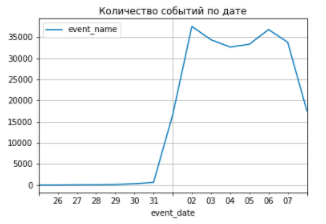

- судя по графику полностью доехали события начиная с 2019-08-02
- удалены неполные данные. Удалили 17798 событий, что составило 7,29% потерь от общего количество записей в логе
- мы располагаем полными данными с 2019-08-02 по 2019-08-08
- В каждой группе есть уникальные пользователи (примерно 2450-2503) после очистки данных 
---

## Как ведут себя пользователи мобильного приложения. 
## Воронка продаж. Как пользователи доходят до покупки. Сколько пользователей доходит до покупки, а сколько — «застревает» на предыдущих шагах? На каких именно?

Воронка представлена цепочкой обытий MainScreenAppear -> OffersScreenAppear -> CartScreenAppear -> PaymentScreenSuccessful
Мы не учитывали событие Tutorial для расчета воронки, так как оно не обязательно для совершения покупки.

Воронка продаж выглядит так:

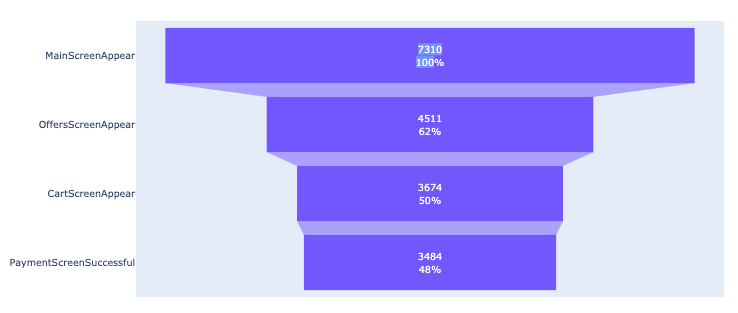

- MainScreenAppear 7319 (100%) -> 
- OffersScreenAppear 4511 (62%) -> 
- CartScreenAppear 3674 (50%) -> 
- PaymentScreenSuccessful 3484 (48%)

Потери:
- на шаге 1  -2799, 
- на шаге 2  -837 , 
- на шаге 3  -190

Наибольшая потеря  -2799 - происходит на шаге 1 - MainScreenAppear - OffersScreenAppear.
Теряется 38% пользователей


## Результаты A/A/B-эксперимента. Дизайнеры захотели поменять шрифты во всём приложении, а менеджеры испугались, что пользователям будет непривычно. Договорились принять решение по результатам A/A/B-теста. Пользователей разбили на 3 группы: 2 контрольные со старыми шрифтами и одну экспериментальную — с новыми. Выясните, какой шрифт лучше.

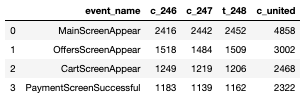



## Сравнение групп А/А (c_246 / c_247). Отличий между контрольными группами c_246 и c_247 нет.

----

## Сравнение групп А1/В (c_246 / t_248). Нет значимой разницы

----

## Сравнение групп А2/В (c_247 / t_248). Есть значимая разница в воронке на шаге OffersScreenAppear-> CartScreenAppear 
- Количество успехов в группе 1:  1139 Количество успехов в группе 2:  1162
- p-значение:  0.0 CartScreenAppear. ! Отвергаем нулевую гипотезу: между долями есть значимая разница
- Есть значимая разница в воронке на шаге OffersScreenAppear-> CartScreenAppear между контрольной группой c_247 и тестовой t_248

----
## Сравнение групп A/B (c_united / t_248). Есть отличия в воронке на шаге OffersScreenAppear -> CartScreenAppear
- Количество успехов в группе 1:  2322 Количество успехов в группе 2:  1162
- p-значение:  0.0 CartScreenAppear. ! Отвергаем нулевую гипотезу: между долями есть значимая разница
- Есть отличия в воронке на шаге OffersScreenAppear -> CartScreenAppear между объединенной контрольной группой и тестовой группой t_248

----

## Какой уровень критической значимости alpha выбрали для проверки статзначимости
- Мы проводим 4 попарных сравнения: АА, А1В, А2В, АВ
- При проверке 4 событий в 4 сравнениях всего получается 4*4=16 проверок
- Исходно я взяла уровень значимости alpha равным 0.05. После ответа на этот и последующий вопросы в расчеты внесены изменения, уровень значимости принят  0.003125

# Воронка в тестовой группе выглядит так:
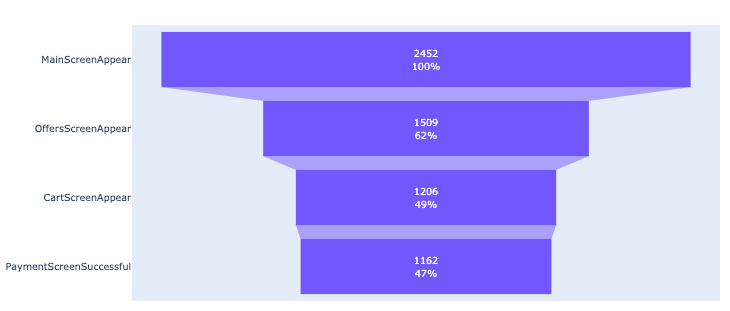

Воронка
- MainScreenAppear 2452 (100%) ->
- OffersScreenAppear 1509 (62%) ->
- CartScreenAppear 1206 (49%) ->
- PaymentScreenSuccessful 1162 (47%)

Значимые отличия по сравнению с контрольными группами найдено в A/B тесте и A2/B сравнении.
В тестовой группе доходит до успешного экрана оплаты 47%, а в контрольной - 48%.
Различия значимы. Следовательно, новый шрифт хуже, чем в контрольной группе. Экперимент неуспешен.